In [1]:
import torch
import torchvision
import datasets
import utils
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm.notebook import tqdm

from signature import signature

In [2]:
data = datasets.TDSCForClassification()

#benign: 1065, #malignant: 2105


(111, 164) 0.0
3170


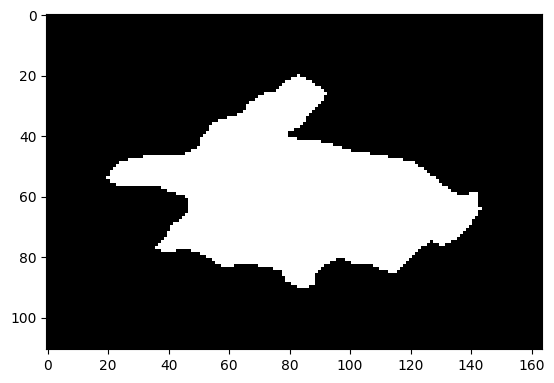

In [3]:
_,x,y = data[0]
print(x.shape, y)
plt.imshow(x, cmap="gray")

print(len(data))

In [4]:
s = signature(x)
print(s)

[37.       29.017237 29.068884 38.209946 21.213203 17.262676 18.439089
 20.615528 29.12044  26.24881  26.57066  34.539833 34.0147   24.596748
 34.       24.186773 24.698177 33.83785  25.       32.80244  32.649654
 26.907248 27.58623  29.       29.732138 31.241    34.20526  37.202152
 36.05551  41.340054 35.846897 36.23534  35.77709  36.249138 43.081318
 35.1141   35.735138 36.40055  45.35416  52.17279  45.705578 51.47815
 57.31492  58.137768 58.034473 62.       57.035076 43.104523 37.215588
 36.345562 45.705578 44.911022 36.138622 36.40055  38.8973   41.4367
 37.696156 46.09772  47.853943 48.76474  30.016663 28.301943 26.627054
 37.202152 24.207438 23.43075  22.671568 34.655445 34.655445 21.260292
 34.058773 32.80244  20.       28.84441  28.301943 27.784887 19.235384
 18.788294 27.313    26.925823 26.57066  25.298222 25.       25.70992
 18.439089 18.248287 35.35534  29.15476  29.068884 29.017237 27.
 29.017237 29.068884 38.209946 21.213203 17.262676 18.439089 20.615528
 29.12044  26.24

In [6]:
data_features = []
for _,x,y in tqdm(data):
    s = signature(x, res=1)
    data_features.append((s, y))


  0%|          | 0/3170 [00:00<?, ?it/s]

In [7]:
class SignatureData(torch.utils.data.Dataset):
    
    def __init__(self, data):
        self.data = data_features
        
    def __getitem__(self, index):
        x,y = self.data[index]
        x = torch.tensor(x).unsqueeze(0)
        y = torch.tensor(y).unsqueeze(0)
        
        return x,y
    
    def __len__(self):
        return len(self.data)
    

data = SignatureData(data_features)
print(len(data))

3170


In [8]:
data_loader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)

In [12]:
learning_rate = 10e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 100


model = torch.nn.Sequential(
    torch.nn.Linear(360, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 1),
)

In [13]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

In [ ]:
for epoch in range(num_epochs):
    data_loop = tqdm(data_loader)
    for data in data_loop:
        x, y = data
        y = y.unsqueeze(1)
        x = x.to(device)
        y = y.to(device)
        
        with torch.cuda.amp.autocast():
             predictions = model(x)
             loss = criterion(predictions, y)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        data_loop.set_postfix(loss=loss.item())
    
    utils.torch.calculate_accuracy(data_loader, model, device)

  0%|          | 0/199 [00:00<?, ?it/s]

Got 2083/3170 with acc 65.71


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2088/3170 with acc 65.87


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2149/3170 with acc 67.79


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2143/3170 with acc 67.60


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2201/3170 with acc 69.43


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2147/3170 with acc 67.73


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2172/3170 with acc 68.52


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2137/3170 with acc 67.41


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2190/3170 with acc 69.09


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2141/3170 with acc 67.54


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2186/3170 with acc 68.96


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2178/3170 with acc 68.71


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2101/3170 with acc 66.28


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2074/3170 with acc 65.43


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2169/3170 with acc 68.42


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2173/3170 with acc 68.55


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2198/3170 with acc 69.34


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2116/3170 with acc 66.75


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2204/3170 with acc 69.53


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2166/3170 with acc 68.33


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2189/3170 with acc 69.05


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2118/3170 with acc 66.81


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2169/3170 with acc 68.42


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2137/3170 with acc 67.41


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2161/3170 with acc 68.17


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2204/3170 with acc 69.53


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2162/3170 with acc 68.20


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2134/3170 with acc 67.32


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2176/3170 with acc 68.64


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2201/3170 with acc 69.43


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2197/3170 with acc 69.31


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2182/3170 with acc 68.83


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2197/3170 with acc 69.31


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2159/3170 with acc 68.11


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2164/3170 with acc 68.26


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2188/3170 with acc 69.02


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2124/3170 with acc 67.00


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2162/3170 with acc 68.20


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2213/3170 with acc 69.81


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2220/3170 with acc 70.03


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2141/3170 with acc 67.54


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2192/3170 with acc 69.15


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2205/3170 with acc 69.56


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2221/3170 with acc 70.06


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2183/3170 with acc 68.86


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2182/3170 with acc 68.83


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2198/3170 with acc 69.34


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2193/3170 with acc 69.18


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2206/3170 with acc 69.59


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2138/3170 with acc 67.44


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2241/3170 with acc 70.69


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2208/3170 with acc 69.65


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2170/3170 with acc 68.45


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2173/3170 with acc 68.55


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2221/3170 with acc 70.06


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2207/3170 with acc 69.62


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2200/3170 with acc 69.40


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2215/3170 with acc 69.87


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2221/3170 with acc 70.06


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2222/3170 with acc 70.09


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2166/3170 with acc 68.33


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2194/3170 with acc 69.21


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2188/3170 with acc 69.02


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2259/3170 with acc 71.26


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2177/3170 with acc 68.68


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2239/3170 with acc 70.63


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2156/3170 with acc 68.01


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2197/3170 with acc 69.31


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2157/3170 with acc 68.04


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2221/3170 with acc 70.06


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2180/3170 with acc 68.77


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2158/3170 with acc 68.08


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2215/3170 with acc 69.87


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2171/3170 with acc 68.49


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2165/3170 with acc 68.30


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2114/3170 with acc 66.69


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2220/3170 with acc 70.03


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2220/3170 with acc 70.03


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2227/3170 with acc 70.25


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2200/3170 with acc 69.40


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2213/3170 with acc 69.81


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2145/3170 with acc 67.67


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2207/3170 with acc 69.62


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2191/3170 with acc 69.12


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2204/3170 with acc 69.53


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2169/3170 with acc 68.42


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2186/3170 with acc 68.96


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2166/3170 with acc 68.33


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2264/3170 with acc 71.42


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2116/3170 with acc 66.75


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2179/3170 with acc 68.74


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2237/3170 with acc 70.57


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2226/3170 with acc 70.22


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2199/3170 with acc 69.37


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2225/3170 with acc 70.19


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2210/3170 with acc 69.72


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2243/3170 with acc 70.76


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2229/3170 with acc 70.32


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2213/3170 with acc 69.81


  0%|          | 0/199 [00:00<?, ?it/s]

Got 2272/3170 with acc 71.67


In [1]:
utils.torch.calculate_accuracy(data_loader, model, device)

NameError: name 'utils' is not defined